# Summary

This notebook will walk through two different access and transformation options across a single dataset available in the Earthdata Cloud: 
1. Direct s3 access using the [earthaccess](https://github.com/nsidc/earthaccess) python library
2. [Harmony](https://harmony.earthdata.nasa.gov/) transformation services 

These steps are based off of several notebook tutorials presented during the [2021 Earthdata Cloud Hackathon](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/) and [2021 AGU Workshop](https://nasa-openscapes.github.io/2021-Cloud-Workshop-AGU/), as well as NSIDC DAAC's [Accessing and working with ICESat-2 data in the cloud](https://github.com/nsidc/NSIDC-Data-Tutorials/tree/main/notebooks/ICESat-2_Cloud_Access) tutorial.

TODO: Describe dataset, ideally with Worldview image if available. Need to decide whether to stick with MODIS or MUR data (higher resolution but difficult to load into memory in small instance).

We will search for, and access, a single netCDF file from inside the AWS cloud (us-west-2 region, specifically) and load it into Python as an `xarray` `dataset`. This approach leverages S3 native protocols for efficient access to the data.

After inspecting the data, we will then access the same file, but in this case we will also subset the data to our area of interest using Harmony. 

## Learning Objectives

- how to retrieve temporary S3 credentials for in-region direct S3 bucket access
- how to define a dataset of interest and find netCDF files in S3 bucket
- how to perform in-region direct access of MODIS_T-JPL-L2P-v2019.0 data in S3
- how to plot the data

---

# 0. Cloud Environment Setup 

## Step 1. Login to the Hub

Please go to the [NASA Openscapes 2i2c JupyterHub](https://openscapes.2i2c.cloud/) and click "Log in to continue", which will bring us to the CILogon page. With "Github" selected as the Identity Provider, click "Log On" and sign in with your GithHub account. We then have the option to select the server type and size. For this tutorial, we will select the default options: "Python" and "Small". Select "Start" to spin up the cloud environment instance. 

*Note: It may take a few moments for the Hub to load. Please be patient!*

TODO: Include screenshots here?

## Step 2. JupyterLab orientation

Once the Hub is loaded, we have access to a JupyterLab interface. 

### First impressions
* Home directory on the lefthand navigation panel
* Blue "Plus" button to open the Launcher
    * Create new files including Jupyter Notebook (.ipynb)
    * Open Terminal window to interact on the command line
    * Restarting the Kernel under "Kernel" menu at the top of the screen. 

TODO: Include screenshots here?

## Step 3. Navigate to the Earthdata Cookbook folder
The folder `earthdata-cloud-cookbook` is in the /shared folder on JupyterHub.

TODO: Is this up to date? If not, how do we update it?

## Jupyter notebooks
Let’s get oriented to Jupyter notebooks, which we’ll use for this clinic.

## How do I end my session?
(Also see [How do I end my Openscapes session? Will I lose all of my work?](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/clinic/jupyterhub.html#how-do-i-end-my-openscapes-session))

When you are finished working for the day it is important to explicitly log out of your Openscapes session. The reason for this is it will save us a bit of money! When you keep a session active it uses up AWS resources and keeps a series of virtual machines deployed.

Stopping the server happens automatically when you log out, so navigate to “File -> Log Out” and just click “Log Out”!

!!! NOTE “logging out” - Logging out will NOT cause any of your work to be lost or deleted. It simply shuts down some resources. It would be equivalent to turning off your desktop computer at the end of the day.

TODO: Can we do some fancy Quarto styling here with an info graphic?

---

# 1. Prerequisites

## AWS instance running in us-west-2

NASA Earthdata Cloud data in S3 can be directly accessed via temporary credentials; this access is limited to requests made within the US West (Oregon) (code: us-west-2) AWS region.

TODO: Back up and walk through what S3 is and the fact that the Hub is running in us-west-2

## Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit <https://urs.earthdata.nasa.gov> to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.


---

## Import Required Packages

In [1]:
# NOTE: We need to update our Hub with the latest version!!
%pip install git+https://github.com/nsidc/earthaccess.git@auth-improvements

  Cloning https://github.com/nsidc/earthaccess.git (to revision auth-improvements) to /tmp/pip-req-build-mtl7kq2s
  Running command git clone --filter=blob:none --quiet https://github.com/nsidc/earthaccess.git /tmp/pip-req-build-mtl7kq2s
  Running command git checkout -b auth-improvements --track origin/auth-improvements
  Switched to a new branch 'auth-improvements'
  Branch 'auth-improvements' set up to track remote branch 'auth-improvements' from 'origin'.
  Resolved https://github.com/nsidc/earthaccess.git to commit e80d167e61216b037646a3b573e91dea4c2b4dc6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
# NOTE: We need to update our Hub with harmony-py!!
%pip install -U harmony-py

Note: you may need to restart the kernel to use updated packages.


In [22]:
# earthaccess
import earthaccess 
print("earthaccess version =", earthaccess.__version__) #should be v0.5.2

# Direct access

#import requests
import s3fs
from pprint import pprint
import xarray as xr
#import hvplot.xarray

# Harmony

from harmony import BBox, Client, Collection, Request, LinkType
#from harmony.config import Environment
#from pprint import pprint
import datetime as dt

earthaccess version = 0.5.2


## 1. Authentication for NASA Earthdata 

The first step is to get the correct authentication that will allow us to get cloud-hosted data from NASA. This is all done through Earthdata Login. The `login` method also gets the correct AWS credentials.

Login requires your Earthdata Login username and password. The login method will automatically search for these credentials as environment variables or in a .netrc file, and if those aren't available it will prompt us to enter our username and password. Below we use a .netrc strategy. A .netrc file is a text file located in our home directory that contains login information for remote machines. If we don't have a .netrc file, `login` can create one for us.

See the [appendix]("https://nasa-openscapes.github.io/earthdata-cloud-cookbook/appendix/authentication.html") for more information on [Earthdata Login]("https://urs.earthdata.nasa.gov/") and netrc setup. This basic line below to create an earthaccess Client assumes that we have a .netrc available.

In [4]:
auth = earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 06/16/2023
Using .netrc file for EDL


___
## 2. Accessing a NetCDF4/HDF5 File - S3 Direct Access

### Summary

We will access a single netCDF file from the GHRSST MODIS L2 dataset (MODIS_T-JPL-L2P-v2019.0) inside the AWS cloud (us-west-2 region, specifically) and load it into Python as an `xarray` `dataset`. This approach leverages S3 native protocols for efficient access to the data.


### Search for data

`earthaccess` leverages the Common Metadata Repository (CMR) API to search for collections and granules. Earthdata Search also uses the CMR API.

We can use the keyword method for collection_query to search for ICESat-2 collections.

TODO: Can I search by hour below?

TODO: I use DOI to search by dataset `earthaccess.search_datasets()` but not if I switch to `earthaccess.search_data`. I don't fully understand the difference between the two and when I would use these vs dataset and granule queries (`earthaccess.granule_query()`).

In [5]:
short_name="MUR-JPL-L4-GLOB-v4.1"

results = earthaccess.search_data(
    #doi="10.5067/GHGMR-4FJ04",
    short_name=short_name,
    cloud_hosted=True,
    temporal=("2021-03-10", "2021-03-10"),
    #temporal=("2021-03-10T10:00:00Z", "2021-03-10T10:00:00Z"),
    bounding_box=(-125.469,15.820,-99.453,35.859)
)

Granules found: 1


Discover information about the matching files:

In [8]:
pprint(results)

[{'meta': {'concept-id': 'G2028276663-POCLOUD',
           'concept-type': 'granule',
           'format': 'application/vnd.nasa.cmr.umm+json',
           'native-id': '20210310090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
           'provider-id': 'POCLOUD',
           'revision-date': '2021-11-14T21:33:37.003Z',
           'revision-id': 3},
  'size': 0,
  'umm': {'CollectionReference': {'ShortName': 'MUR-JPL-L4-GLOB-v4.1',
                                  'Version': '4.1'},
          'DataGranule': {'ArchiveAndDistributionInformation': [{'Checksum': {'Algorithm': 'MD5',
                                                                              'Value': 'afa0c9a4940684245531c84c50b9c08b'},
                                                                 'Name': '20210310090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
                                                                 'Size': 725.048526763916,
                                                             

### Direct In-region Access

Stream data directly to xarray:

In [9]:
ds = xr.open_mfdataset(earthaccess.open(results))
ds

 Opening 1 granules, approx size: 0.0 GB


SUBMITTING | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 2021-03-10T09:00:00
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(1, 17999, 36000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Note: Plotting is too much for the small instance (I think I saw ~20 GB of memory going before it crashed). But let's try to extract just the time and spatial range of interest:

In [12]:
ds_subset = ds['analysed_sst'].sel(lat=slice(15.820, 35.859), lon=slice(-125.469,-99.453))
ds_subset

<xarray.DataArray 'analysed_sst' (time: 1, lat: 2003, lon: 2601)>
dask.array<getitem, shape=(1, 2003, 2601), dtype=float32, chunksize=(1, 2003, 2601), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2021-03-10T09:00:00
  * lat      (lat) float32 15.83 15.84 15.85 15.86 ... 35.82 35.83 35.84 35.85
  * lon      (lon) float32 -125.5 -125.4 -125.4 -125.4 ... -99.48 -99.47 -99.46
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, A...

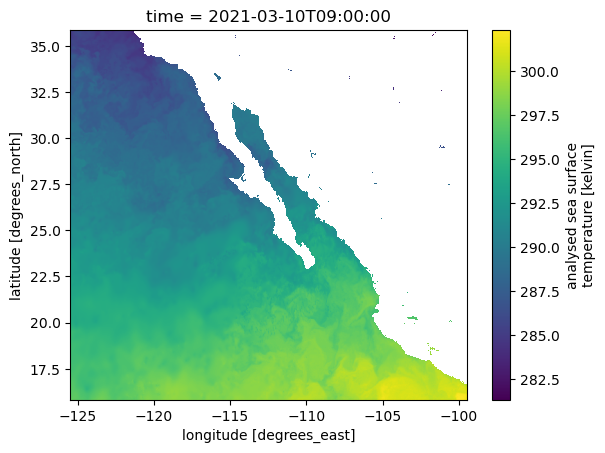

In [13]:
ds_subset.plot()

---

## 3. Accessing Multiple NetCDF4/HDF5 Files - Data Subsetting and Transformation Services in the Cloud

### Using the Harmony-Py library to access customized data from NASA Earthdata 

#### What other access options or services exist for this dataset?

Maybe we're interested in creating a time series over a larger area or with a larger dataset. Let's see whether there are other services out there that could either make this operation more performant in the cloud (with a cloud-optimized output) or subsetting services to reduce the data volume.

Based off of https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/07_Harmony_Subsetting.html 

### Summary

We have already explored direct access to the NASA EOSDIS archive in the cloud via the Amazon Simple Storage Service (S3) by using the Common Metadata Repository (CMR) to search for granule locations. In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection, and other transformations. 

This tutorial demonstrates how to find, request, and use customized data from a new ecosystem of services operating within the NASA Earthdata Cloud: NASA Harmony.

### Benefits

But first, why use this option when we've already learned how to access data directly from the NASA Earthdata Cloud? 

- Consistent access patterns to EOSDIS holdings make cross-data center data access easier
- Data reduction services allow us to request only the data we want, in the format and projection we want
- Analysis Ready Data and cloud access will help reduce time-to-science
- Community Development helps reduce the barriers for re-use of code and sharing of domain knowledge

See more on the [Earthdata Harmony landing page](https://harmony.earthdata.nasa.gov/), including documentation on the Harmony API itself. 


### Objectives

1. Conceptualize the data transformation service types and offerings provided by NASA Earthdata, including Harmony.
2. Practice skills learned from the introductory CMR tutorial to discover what access and service options exist for a given data set, as well as variable metadata.
3. Utilize the Harmony-py library to request subsetted MODIS L2 Sea Surface Temperature data over the Gulf of Mexico. 
4. Read Harmony subsetted outputs directly into xarray. 

## Discover service options for a given data set

#### _First, what do we mean by a "service"?_

In the context of NASA Earthdata, we are usually referring to a service as any data transformation or customization process that packages or delivers data in a way that makes it easier to work with compared to how the data are natively archived at NASA EOSDIS. Basic customization options may include:
* Subsetting (cropping) the data by:
    * Variable
    * Spatial boundary,
    * Temporal range
* Reformatting
    * For example: From NetCDF-4 to Cloud Optimized GeoTIFF
* Reprojection and/or Resampling
    * For example: From Sinusoidal to Polar Stereographic
* Mosaicking
* Aggregating

A few main types or pathways for services that are commonly supported across the NASA DAACs include:
* [NASA Global Imagery Browse Service](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/gibs)
    * Web services providing imagery, much of which is updated daily, to broaden accessibility of NASA EOSDIS data to the media and public.
* [OPeNDAP](https://opendap.earthdata.nasa.gov/)
    * The Open-source Project for a Network Data Access Protocol is a NASA community standard DAP that provides a simple way to access and work with data over the internet. OPeNDAP's client/server software allows us to subset and reformat data using an internet browser, command line interface, and other applications.
* [Harmony](https://harmony.earthdata.nasa.gov/)
    * In the most basic sense, Harmony is an Application Programming Interface, or API, allowing us to request customization options described above, which are then processed and returned as file outputs. Harmony helps to reduce pre-processing steps so we can spend less time preparing the data, and more time doing science.  

**Note: These service offerings are unique to each NASA EOSDIS dataset.**

Why is this?

Due to varying [levels of service](https://earthdata.nasa.gov/collaborate/new-missions/level-of-service), cloud migration status, and unique characteristics of the datasets themselves, not all service options are provided for all datasets. Therefore it is important to first explore a given dataset's metadata to discover what service options are provided.

#### Note that the full [Harmony tutorial](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/07_Harmony_Subsetting.html) from the 2021 Earthdata Cloud Hackathon demonstrates service and variable discovery, but this was removed here for simplification.

## Using Harmony-Py to subset data

Harmony-Py provides a pip installable Python alternative to directly using Harmony's RESTful API to make it easier to request data and service options, especially when interacting within a Python Jupyter Notebook environment.

The next steps are adopted from the [introduction tutorial](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) notebook provided in the Harmony-Py library:

### Create Harmony Client object
First, we need to create a Harmony Client, which is what we will interact with to submit and inspect a data request to Harmony, as well as to retrieve results.

When creating the Client, we need to provide Earthdata Login credentials, which are required to access data from NASA EOSDIS. This basic line below assumes that we have a `.netrc` available. 

In [14]:
harmony_client = Client()

### Create Harmony Request

The following are common request parameters:

- `collection`: Required parameter. This is the NASA EOSDIS collection, or data product. There are two options for inputting a collection of interest:
    - Provide a concept ID (e.g. C1940473819-POCLOUD)
    - Data product short name (e.g. MODIS_A-JPL-L2P-v2019.0).
- `spatial`: Bounding box spatial constraints on the data. The Harmony Bbox class accepts spatial coordinates as decimal degrees in w, s, e, n order, where longitude = -180, 180 and latitude = -90, 90.
- `temporal`: Date/time constraints on the data. The example below demonstrates temporal start and end ranges using the python datetime library.

As we identified above, only subsetting options are available for this dataset. If other service options such as reformatting are available for a given dataset, these can also be specified using Harmony-py: See the [documentation](https://harmony-py.readthedocs.io/en/latest/) for details on how to construct these parameters.


In [15]:
request = Request(
    collection=Collection(id=short_name),
    spatial=BBox(-125.469,15.820,-99.453,35.859),
    temporal={
    'start': dt.datetime(2021, 3, 10, 1),
    'stop': dt.datetime(2021, 3, 10, 2)
    }
)

### Submit request

Now that the request is created, we can now submit it to Harmony using the Harmony Client object. A job id is returned, which is a unique identifier that represents the submitted request.

In [16]:
job_id = harmony_client.submit(request)
job_id

'2499c8fc-4e74-4284-bcaa-fe7d3187ec1a'

### Check request status

Depending on the size of the request, it may be helpful to wait until the request has completed processing before the remainder of the code is executed. The wait_for_processing() method will block subsequent lines of code while optionally showing a progress bar.

In [17]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


### View Harmony job response and output URLs
Once the data request has finished processing, we can view details on the job that was submitted to Harmony, including the API call to Harmony, and informational messages on the request if available.

result_json() calls wait_for_processing() and returns the complete job in JSON format once processing is complete. 

In [18]:
data = harmony_client.result_json(job_id)
pprint(data)

{'createdAt': '2023-05-15T18:53:04.392Z',
 'dataExpiration': '2023-06-14T18:53:04.392Z',
 'jobID': '2499c8fc-4e74-4284-bcaa-fe7d3187ec1a',
 'links': [{'href': 'https://harmony.earthdata.nasa.gov/stac/2499c8fc-4e74-4284-bcaa-fe7d3187ec1a/',
            'rel': 'stac-catalog-json',
            'title': 'STAC catalog',
            'type': 'application/json'},
           {'bbox': [-180, -90, 180, 90],
            'href': 'https://harmony.earthdata.nasa.gov/service-results/harmony-prod-staging/public/2499c8fc-4e74-4284-bcaa-fe7d3187ec1a/14212506/20210310090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04_subsetted.nc4',
            'rel': 'data',
            'temporal': {'end': '2021-03-10T21:00:00.000Z',
                         'start': '2021-03-09T21:00:00.000Z'},
            'title': '20210310090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04_subsetted.nc4',
            'type': 'application/x-netcdf4'},
           {'href': 'https://harmony.earthdata.nasa.gov/jobs/2499c8fc-4e74-4284-bcaa-fe7d318

### Direct cloud access

Note that the remainder of this tutorial will only succeed when running this notebook within the AWS us-west-2 region.

Harmony data outputs can be accessed within the cloud using the s3 URLs and AWS credentials provided in the Harmony job response.

#### Retrieve list of output URLs.

The result_urls() method calls wait_for_processing() and returns a list of the processed data URLs once processing is complete. You may optionally show the progress bar as shown below.

In [19]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
urls = list(results)
url = urls[0]
print(url)

s3://harmony-prod-staging/public/2499c8fc-4e74-4284-bcaa-fe7d3187ec1a/14212506/20210310090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04_subsetted.nc4


#### Using earthaccess to open URL from Harmony

TODO: Can we take Harmony's s3 URL and open directly a la `ds = xr.open_mfdataset(earthaccess.open(results))`? I'm not quite sure how to take a link or list of links and input it so it has the same structure as what you'd get from `earthaccess.open(results)`.

Using `aws_credentials` you can retrieve the credentials needed to access the Harmony s3 staging bucket and its contents.

In [20]:
creds = harmony_client.aws_credentials()

### Open staged files with *s3fs* and *xarray*

We use the AWS `s3fs` package to create a file system that can then be read by xarray:

In [23]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

Now that we have our s3 file system set, including our declared credentials, we'll use that to open the url, and read in the file through xarray. This extra step is needed because xarray cannot open the S3 location directly. Instead, the S3 file object is passed to xarray, in order to then open the dataset. 

In [24]:
f = s3_fs.open(url, mode='rb')
ds = xr.open_dataset(f)
ds

<xarray.Dataset>
Dimensions:           (time: 1, lat: 2005, lon: 2603)
Coordinates:
  * lat               (lat) float32 15.82 15.83 15.84 ... 35.84 35.85 35.86
  * lon               (lon) float32 -125.5 -125.5 -125.4 ... -99.46 -99.45
  * time              (time) datetime64[ns] 2021-03-10T09:00:00
Data variables:
    mask              (time, lat, lon) float32 ...
    analysed_sst      (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
    analysis_error    (time, lat, lon) float32 ...
    sst_anomaly       (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    history_json:               [{"$schema":"https:\/\/harmony.earthdata.nasa...

### Plot the data

Use the xarray built in plotting function to create a simple plot along the x and y dimensions of the dataset:

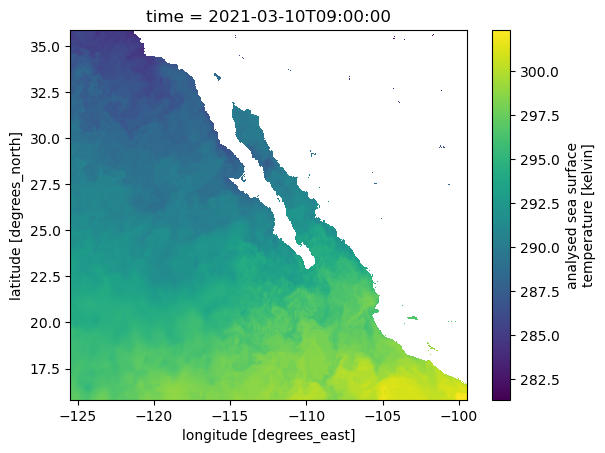

In [26]:
ds.analysed_sst.plot() ;

### Summary

This notebook demonstrated an abbreviated and simplified workflow to explore access and subsetting options available through the Earthdata Cloud. There are several other options that can be used to work "in place" in the Earthdata Cloud, from data discovery to analysis-ready data, including: 

* [Zarr-EOSDIS-Store](https://github.com/nasa/zarr-eosdis-store)
    * The zarr-eosdis-store library allows NASA EOSDIS Collections to be accessed efficiently by the Zarr Python library, provided they have a sidecar DMR++ metadata file generated. 
    * Tutorial highlighting this library's usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/09_Zarr_Access.html 
* [OPeNDAP](https://opendap.earthdata.nasa.gov/) 
    * Hyrax provides direct access to subsetting of NASA data using Python or your favorite analysis tool
    * Tutorial highlighting OPeNDAP usage: https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/06_S6_OPeNDAP_Access_Gridding.html
* [Earthaccess Library](https://github.com/nsidc/earthdaccess)
    * A Python library to search and access NASA Earthdata datasets, aiming to provide a simple way to access or download data without having to worry if a given dataset is on-prem or in the cloud.